In [1]:
using Revise

In [2]:
using QuantumStates, UnitsToValue, DataFrames, Plots

[ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]


### Load Hamiltonian

In [5]:
H = load_from_file("CaOH_BendingMode_Hamiltonian", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")

# Add AC Stark effect from trap
au = 1.64877727436e-41
w = 2.2e-6; P = @with_unit 0.150 "W"; I_trap = 2P / (π * w^2);
α_par = 186.5
α_perp = 393.2
const α = [(1/3)*(α_par + 2α_perp), 0, (2/3)*(α_par - α_perp)] .* au
const θ = π/2
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
scalar_polarizability(state, state′) = polarizability(state, state′, α .* [1,0,0], ϵ_trap)
tensor_polarizability(state, state′) = polarizability(state, state′, α .* [0,0,1], ϵ_trap)
H = add_to_H(H, :I_scalar, (1e-6 / h) * scalar_polarizability)
H = add_to_H(H, :I_tensor, (1e-6 / h) * tensor_polarizability)

# Add DC Stark effect
const μX = 1e-6 * 1.465 * (1e-21 / c) / h
H = add_to_H(H, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# Transverse DC Stark shifts
Stark_X(state, state′) = (1/√2) * (Stark_Transverse(state, state′, -1) - Stark_Transverse(state, state′, +1))
H = add_to_H(H, :E_X, (1e2 * μX) * Stark_X)

# Add Zeeman effect
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_z, gS * (1e-10 * μ_B / h) * Zeeman_z)

# Add parity-dependent Zeeman effect
g_N = 1e-3
g_ℓ = H.parameters.γX * 1e6 / (1e2 * 250c)
H = add_to_H(H, :B_z_parity, g_N * (1e-10 * μ_B / h) * g_ℓ * Zeeman_ParityDependent)
;

In [6]:
using LinearAlgebra

In [7]:
r = 2e-6
d_ = (1.465 * (1e-21 / c) / 2)
Ω = (d_^2 / (4π*ε_0*r^3)) / ħ
π / Ω

0.04939702144103356

In [8]:
# Option 1: E = 0, B = 100: idxs = 13, 14, 20
# Option 2: E = 0, B = 10: idxs = 6, 18, X (34?) -- dipolar exchange between "mirror" parity states
# Option 3: E = 400, B = 0, idxs = 9, 12, X?
# Option 4: E = 0, B = 100, idxs = 3, 9, ?? -- mirror states plus two interacting states
# Option 5: E = 1000, B = 0, idxs = 12, 16 (or 9, 13) ?? -- mirror plus two interacting states

In [9]:
# |0⟩ = 18, 1 = 24
# e_1 = 16, e_2 = 22

In [10]:
H.parameters.E = 0.
H.parameters.B_z = 1.5
H.parameters.B_z_parity = 0.
H.parameters.I_scalar = 0 .* (0.4/4) * I_trap / (2ε_0 * c)
H.parameters.I_tensor = 0 .* (0.4/4) * I_trap / (2ε_0 * c)
full_evaluate!(H)
solve!(H)
;

In [11]:
QN_bounds = (S = 1/2, I = 1/2, Λ = [-1,1], N = 1:5)
basis_uncoupled = enumerate_states(HundsCaseB_Decoupled, QN_bounds)
states_uncoupled = convert_basis(H.states, basis_uncoupled)
;

In [12]:
μs = []
for i ∈ eachindex(H.states)
    μ = Float64(1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[i], H.states[i], 0))
    push!(μs, μ)
end

In [13]:
sorted_idxs = sortperm(μs)
sorted_μs = μs[sorted_idxs]
;

In [14]:
_, mF_0_states = subspace(H.states, (M=0,))
;

In [15]:
# # |0⟩ state, opposite nuclear spin states
# idx_0 = 17
# state_0 = states_uncoupled[idx_0]
# 1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_0], H.states[idx_0]) |> display
# 1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_0], H.states[idx_0], 0) |> display
# state_0 |> display
# energy(state_0) |> display

In [16]:
# # |1⟩ state, opposite nuclear spin states
# idx_1 = 18
# state_1 = states_uncoupled[idx_1]
# 1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_1], H.states[idx_1]) |> display
# 1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_1], H.states[idx_1], 0) |> display
# state_1 |> display
# energy(state_1) |> display

In [81]:
# |0⟩ state
idx_0 = 12
state_0 = H.states[idx_0]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_0], H.states[idx_0]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_0], H.states[idx_0], 0) |> display
state_0 |> display
energy(state_0) |> display

-1.6788201602352847e-11 + 0.0im

1401.247246725749 + 0.0im

State{HundsCaseB_Rot}(9986.934142468288, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 0, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -2, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -

9986.934142468288

In [82]:
# |1⟩ state
idx_1 = 24
state_1 = H.states[idx_1]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_1], H.states[idx_1]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_1], H.states[idx_1], 0) |> display
state_1 |> display
energy(state_1) |> display

4.8526778616952505e-11 + 0.0im

1401.2472439149867 + 0.0im

State{HundsCaseB_Rot}(10029.990310355899, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 0, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -2, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, 

10029.990310355899

In [83]:
# |e1⟩ state
idx_e1 = 12
state_e1 = H.states[idx_e1]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_e1], H.states[idx_e1]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_e1], H.states[idx_e1], 0) |> display
state_e1 |> display
energy(state_e1) |> display

-1.6788201602352847e-11 + 0.0im

1401.247246725749 + 0.0im

State{HundsCaseB_Rot}(9986.934142468288, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 0, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -2, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -

9986.934142468288

In [84]:
# |e2⟩ state
idx_e2 = 24
state_e2 = H.states[idx_e2]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_e2], H.states[idx_e2]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_e2], H.states[idx_e2], 0) |> display
state_e2 |> display
energy(state_e2) |> display

4.8526778616952505e-11 + 0.0im

1401.2472439149867 + 0.0im

State{HundsCaseB_Rot}(10029.990310355899, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 0, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -2, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, 

10029.990310355899

In [85]:
# # |e1⟩ state
# idx_e1 = 18
# state_e1 = states_uncoupled[idx_e1]
# 1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_e1], H.states[idx_e1]) |> display
# 1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_e1], H.states[idx_e1], 0) |> display
# state_e1 |> display
# energy(state_e1) |> display

In [86]:
# # |e2⟩ state
# idx_e2 = 24
# state_e2 = states_uncoupled[idx_e2]
# 1e-3 * (1e2 * μX) * 1e6 * d(H.states[idx_e2], H.states[idx_e2]) |> display
# 1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[idx_e2], H.states[idx_e2], 0) |> display
# state_e2 |> display
# energy(state_e2) |> display

In [87]:
# |R1⟩ state
raman_idx1 = 50 #18
state_raman1 = states_uncoupled[raman_idx1]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[raman_idx1], H.states[raman_idx1]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[raman_idx1], H.states[raman_idx1], 0) |> display
state_raman1 |> display
energy(state_raman1) |> display

-1.212594105031147e-11 + 0.0im

98.1320998189477 + 0.0im

State{HundsCaseB_Decoupled}(50004.59808105306, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_

50004.59808105306

In [88]:
# |R2⟩ state
raman_idx2 = 60 #24
state_raman2 = states_uncoupled[raman_idx2]
1e-3 * (1e2 * μX) * 1e6 * d(H.states[raman_idx2], H.states[raman_idx2]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(H.states[raman_idx2], H.states[raman_idx2], 0) |> display
state_raman2 |> display
energy(state_raman2) |> display

-5.418314735953523e-12 + 0.0im

196.37533585485224 + 0.0im

State{HundsCaseB_Decoupled}(50078.716251462894, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M

50078.716251462894

In [89]:
round.(Tuple(TDM(H.states[idx_0], H.states[idx_1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_0], H.states[idx_e1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_1], H.states[idx_e2], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_e1], H.states[idx_e2], p) for p ∈ -1:1), digits=3) |> display

(-0.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im)

(0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im)

(0.0 + 0.0im, 0.0 + 0.0im, -0.0 + 0.0im)

(-0.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im)

In [90]:
TDM_magnetic(H.states[idx_0], H.states[idx_1], 0) |> display

-2.1505908644973938e-14 + 0.0im

In [91]:
using PrettyTables

In [92]:
upleg = energy(state_raman1) - energy(state_0)

40017.663938584774

In [93]:
downleg = energy(state_raman1) - energy(state_e1)

40017.663938584774

In [94]:
upleg - downleg

0.0

In [95]:
# # |N=1, J=1/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
# transitions = compute_transitions(H.states, H.states, 0, threshold=1e-5)
# # transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-5)]
# df = transitions_table(transitions)
# select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
# filter!(row -> 39900 < row.f < 40100, df)
# filter!(row -> row.State == 16, df)

# pretty_table(df; nosubheader=true)

In [96]:
# using Plots
# hline(energy.(H.states), legend=nothing)
# plot!(
#     xticks=nothing,
#     ylabel="Energy (MHz)",
# )

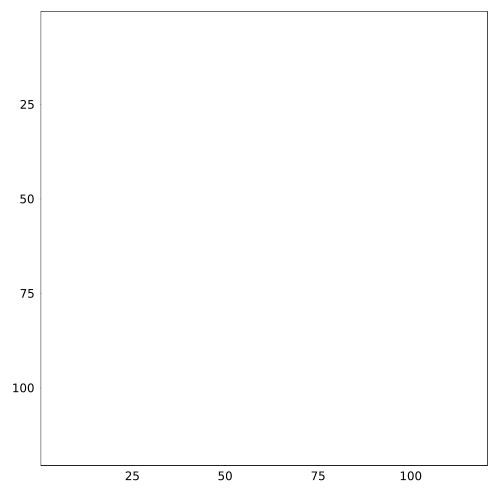

In [97]:
# @time update_basis_tdms!(H)
# @time update_tdms!(H)
heatmap(abs.(real.(H.tdms[:,:,2])), c=cgrad(:hot, rev=true), legend=:none)
plot!(
    size=(500,500),
    box=:on,
    grid=true
    )
yflip!(true)

### N=2 states to perform Raman transitions with

In [98]:
state_raman1

State{HundsCaseB_Decoupled}(50004.59808105306, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_

In [99]:
state_raman2

State{HundsCaseB_Decoupled}(50078.716251462894, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M

In [100]:
round.(Tuple(TDM(H.states[idx_0], H.states[raman_idx1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_0], H.states[raman_idx2], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_1], H.states[raman_idx1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_1], H.states[raman_idx2], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_e1], H.states[raman_idx1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_e1], H.states[raman_idx2], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_e2], H.states[raman_idx1], p) for p ∈ -1:1), digits=3) |> display
round.(Tuple(TDM(H.states[idx_e2], H.states[raman_idx2], p) for p ∈ -1:1), digits=3) |> display

(-0.0 + 0.0im, -0.0 + 0.0im, 0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, 0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, 0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, 0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im)

(-0.0 + 0.0im, -0.0 + 0.0im, -0.0 + 0.0im)

### Stark plots

In [113]:
function H_func!(H, scan_values)
    H.parameters.E_X = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Es = H.parameters.E .+ (0:1:100) .* 1e-3 .+ 10
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.407733 seconds (336.85 k allocations: 185.782 MiB, 114.34% compilation time)


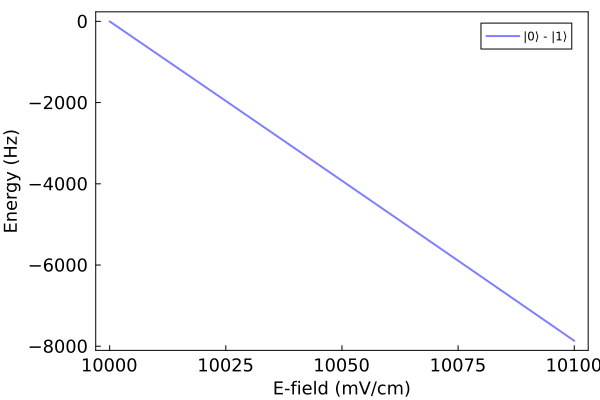

In [114]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,:]'
plot(Es .* 1e3, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_1]), linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩ - |1⟩")
# plot!(Es, 1e6 .* (Es_rel[:,idx_e1] .- Es_rel[:,idx_e2]), linewidth=2, linecolor=:green, alpha=0.5, label="|e₁⟩ - |e₂⟩")
# plot!(Es, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_e1]), linewidth=2, linecolor=:red, alpha=0.5, label="|0⟩ - |e₁⟩")
plot!(
    xlabel="E-field (mV/cm)",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
)

In [116]:
1/8000

0.000125

### Zeeman plots

In [658]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Bs = H.parameters.B_z .+ (0:0.01:1) .* 1e-3
scan_params = (
    B = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.492507 seconds (320.31 k allocations: 184.599 MiB, 49.09% compilation time)


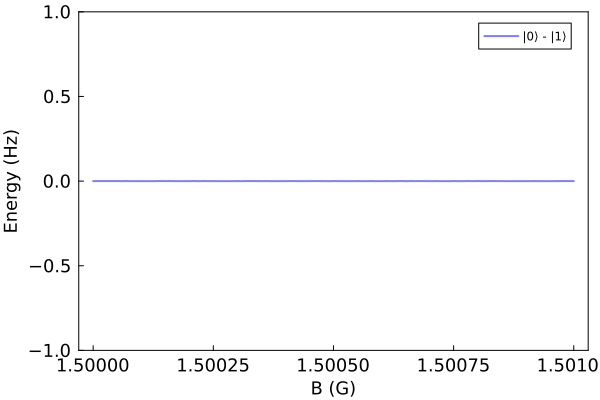

In [659]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,:]'
plot(Bs, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_1]), linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩ - |1⟩")
# plot!(Bs, 1e6 .* (Es_rel[:,idx_e1] .- Es_rel[:,idx_e2]), linewidth=2, linecolor=:green, alpha=0.5, label="|e₁⟩ - |e₂⟩")
# plot!(Bs, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_e1]), linewidth=2, linecolor=:red, alpha=0.5, label="|0⟩ - |e₁⟩")
plot!(
    xlabel="B (G)",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    ylim=(-1,1)
    )

### Trap shift plots

In [660]:
function H_func!(H, scan_values)
    H.parameters.I_scalar = scan_values[1]
    H.parameters.I_tensor = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Is = (0:0.01:1.0) .* (I_trap / (2ε_0 * c))
scan_params = (
    I = Is,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  4.095829 seconds (340.01 k allocations: 185.998 MiB, 3.28% gc time, 156.27% compilation time)


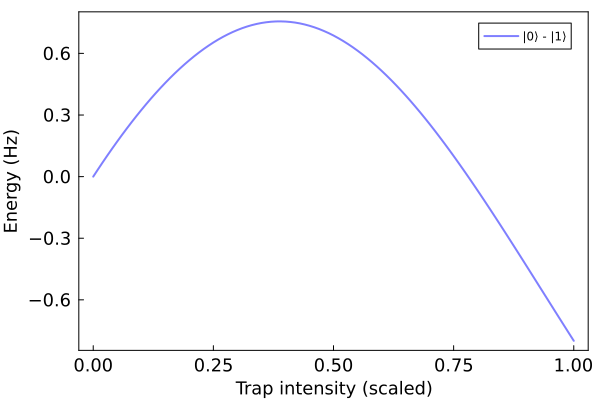

In [661]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,:]'
plot((0:0.01:1.0), 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_1]), linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩ - |1⟩")
# plot!(Is, 1e6 .* (Es_rel[:,idx_e1] .- Es_rel[:,idx_e2]), linewidth=2, linecolor=:green, alpha=0.5, label="|e₁⟩ - |e₂⟩")
# plot!(Is, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_e1]), linewidth=2, linecolor=:red, alpha=0.5, label="|0⟩ - |e₁⟩")
plot!(
    xlabel="Trap intensity (scaled)",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )